### Import Modules

In [39]:
import pickle, gzip, numpy as np, math, matplotlib.pyplot as plt, matplotlib.cm as cm
from sklearn.svm import LinearSVC
import scipy.sparse as sparse

### Import Data

In [40]:
def read_pickle_data(file_name):
    """
    load given file and return data
    """
    with gzip.open(file_name, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    return data


def write_pickle_data(data, file_name):
    with gzip.open(file_name, 'wb') as f:
        pickle.dump(data, f)

def get_MNIST_data():
    """
    Reads mnist dataset from file

    Returns:
        train_x - 2D Numpy array (n, d) where each row is an image
        train_y - 1D Numpy array (n, ) where each row is a label
        test_x  - 2D Numpy array (n, d) where each row is an image
        test_y  - 1D Numpy array (n, ) where each row is a label

    """
    train_set, valid_set, test_set = read_pickle_data('Datasets/mnist.pkl.gz')
    train_x, train_y = train_set
    valid_x, valid_y = valid_set
    # combine train and valid set 
    train_x = np.vstack((train_x, valid_x))
    train_y = np.hstack((train_y, valid_y)) #  train_y = np.append((train_y, valid_y)) 
    test_x, test_y = test_set
    return (train_x, train_y, test_x, test_y)

def plot_images(X):
    # if X is 1D array, convert it to 2D aray
    if X.ndim == 1:
        X = np.array([X])
    num_images = X.shape[0]
    num_rows = math.floor(math.sqrt(num_images))
    num_cols = math.ceil(num_images/num_rows)
    for i in range(num_images):
        reshaped_image = X[i,:].reshape(28,28)
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(reshaped_image, cmap = cm.Greys_r)
        plt.axis("off")
    plt.show()

###  Linear Regression with Closed Form Solution

In [41]:
def closed_form(X, Y, lambda_factor):
    """
    Computes the closed form solution of linear regression with L2 regularization

    Args:
        X - (n, d + 1) NumPy array (n datapoints each with d features plus the bias feature in the first dimension)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        lambda_factor - the regularization constant (scalar)
    Returns:
        theta - (d + 1, ) NumPy array containing the weights of linear regression. Note that theta[0]
        represents the y-axis intercept of the model and therefore X[0] = 1
    """
    # YOUR CODE HERE
    identity_matrix = np.identity(X.shape[1])
    return np.linalg.inv(X.T @ X + lambda_factor * identity_matrix) @ X.T @ Y

In [42]:
def compute_test_error_linear(test_x, Y, theta):
    """
    compute testing error by restricting prediction outcome between 0 and 9, and round to 
    nearest integer 
    """
    test_y_predict = np.round(np.dot(test_x, theta))
    test_y_predict[test_y_predict < 0] = 0
    test_y_predict[test_y_predict > 9] = 9
    return 1 - np.mean(test_y_predict == Y)

In [43]:
def run_linear_regression_on_MNIST(lambda_factor=1):
    """
    Trains linear regression, classifies test data, computes test error on test set

    Returns:
        Final test error
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    # add bias term, so X becomes (n, d + 1) with n data points, d+1 features(first feature is bias)
    train_x_bias = np.hstack([np.ones([train_x.shape[0], 1]), train_x])
    test_x_bias = np.hstack([np.ones([test_x.shape[0], 1]), test_x])
    theta = closed_form(train_x_bias, train_y, lambda_factor)
    test_error = compute_test_error_linear(test_x_bias, test_y, theta)
    return test_error

train_x, train_y, test_x, test_y = get_MNIST_data()

# Don't run this until the relevant functions in linear_regression.py have been fully implemented.
print('lambda=1, Linear Regression test_error =', run_linear_regression_on_MNIST(lambda_factor=1))
print('lambda=0.1, Linear Regression test_error =', run_linear_regression_on_MNIST(lambda_factor=0.1))
print('lambda=0.01, Linear Regression test_error =', run_linear_regression_on_MNIST(lambda_factor=0.01))

MemoryError: Unable to allocate 359. MiB for an array with shape (785, 60000) and data type float64

### SVM

In [44]:
def one_vs_rest_svm(train_x, train_y, test_x):
    """
    Trains a linear SVM for binary classifciation

    Args:
        train_x - (n, d) NumPy array (n datapoints each with d features)
        train_y - (n, ) NumPy array containing the labels (0 or 1) for each training data point
        test_x - (m, d) NumPy array (m datapoints each with d features)
    Returns:
        pred_test_y - (m,) NumPy array containing the labels (0 or 1) for each test data point
    """
    model = LinearSVC(random_state = 0, C=0.1)
    model.fit(train_x, train_y)
    return model.predict(test_x)

def multi_class_svm(train_x, train_y, test_x):
    """
    Trains a linear SVM for multiclass classifciation using a one-vs-rest strategy

    Args:
        train_x - (n, d) NumPy array (n datapoints each with d features)
        train_y - (n, ) NumPy array containing the labels (int) for each training data point
        test_x - (m, d) NumPy array (m datapoints each with d features)
    Returns:
        pred_test_y - (m,) NumPy array containing the labels (int) for each test data point
    """
    model = LinearSVC(random_state = 0, C=0.1)
    model.fit(train_x, train_y)
    return model.predict(test_x)
    

def compute_test_error_svm(test_y, pred_test_y):
    return 1 - np.mean(pred_test_y == test_y)


In [45]:
def run_svm_one_vs_rest_on_MNIST():
    """
    Trains svm, classifies test data, computes test error on test set

    Returns:
        Test error for the binary svm
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    train_y[train_y != 0] = 1
    test_y[test_y != 0] = 1
    pred_test_y = one_vs_rest_svm(train_x, train_y, test_x)
    test_error = compute_test_error_svm(test_y, pred_test_y)
    return test_error

def run_multiclass_svm_on_MNIST():
    """
    Trains svm, classifies test data, computes test error on test set

    Returns:
        Test error for multi-class svm
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    pred_test_y = multi_class_svm(train_x, train_y, test_x)
    test_error = compute_test_error_svm(test_y, pred_test_y)
    return test_error

In [46]:
print('binaryclass SVM test_error =', run_svm_one_vs_rest_on_MNIST())

MemoryError: Unable to allocate 359. MiB for an array with shape (60000, 784) and data type float64

In [ ]:
print('multiclass SVM test_error =', run_multiclass_svm_on_MNIST())

###  Multinomial (Softmax) Regression and Gradient Descent

In [20]:
def augment_feature_vector(X):
    """
    Adds the x[i][0] = 1 feature for each data point x[i].

    Args:
        X - a NumPy matrix of n data points, each with d - 1 features

    Returns: X_augment, an (n, d) NumPy array with the added feature for each datapoint
    """
    column_of_ones = np.ones([len(X), 1])
    return np.hstack((column_of_ones, X))

def compute_probabilities(X, theta, temp_parameter):
    """
    Computes, for each datapoint X[i], the probability that X[i] is labeled as j
    for j = 0, 1, ..., k-1

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        theta - (k, d) NumPy array, where row j represents the parameters of our model for label j
        temp_parameter - the temperature parameter of softmax function (scalar)
    Returns:
        H - (k, n) NumPy array, where each entry H[j][i] is the probability that X[i] is labeled as j
    """
    #YOUR CODE HERE
    # calcuate constant c to avoid overflow error
    theta_max = np.amax(theta, axis=0)
    c = theta_max @ X.T/temp_parameter
    # prob_matrix which represent individual probabilities where H[j][i] is the probability that X[i] is labeled as j
    val_matrix = np.exp(theta @ X.T/temp_parameter - c)
    sum_prob = np.sum(val_matrix, axis=0)
    prob_matrix = val_matrix / sum_prob
    return prob_matrix
    

def compute_cost_function(X, Y, theta, lambda_factor, temp_parameter):
    """
    Computes the total cost over every datapoint.

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        lambda_factor - the regularization constant (scalar)
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns
        c - the cost value (scalar)
    """
    n = len(X)
    k, d = theta.shape

    # Calculate the softmax probabilities
    probabilities = compute_probabilities(X, theta, temp_parameter)

    # Calculate the cost function
    cost = -np.sum(np.log(probabilities[Y, range(n)])) / n
    cost += lambda_factor / 2 * np.sum(theta ** 2)

    # calculate the regularization term
    regularization = (lambda_factor / 2) * np.sum(theta ** 2)

    # Add the regularization term to the cost
    cost += regularization
    return cost

def run_gradient_descent_iteration(X, Y, theta, alpha, lambda_factor, temp_parameter):
    """
    Runs one step of batch gradient descent

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        alpha - the learning rate (scalar)
        lambda_factor - the regularization constant (scalar)
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        theta - (k, d) NumPy array that is the final value of parameters theta
    """
    #YOUR CODE HERE
    n, d = X.shape
    k = theta.shape[0]

    # Convert X and Y to sparse matrices
    X_sparse = sparse.coo_matrix(X)
    Y_sparse = sparse.coo_matrix(Y)

    # Calculate the softmax probabilities using sparse matrix operations
    probabilities = compute_probabilities(X_sparse, theta, temp_parameter)

    # Calculate the indicator matrix using sparse matrix operations
    indicator_matrix = sparse.coo_matrix(([1] * n, (Y, range(n))), shape=(k, n)).toarray()

    # Compute the gradient
    gradient = -(indicator_matrix - probabilities) @ X_sparse / (temp_parameter * n)

    # Calculate the regularization term
    regularization_term = lambda_factor * theta

    # Update theta using gradient descent
    theta -= alpha * (gradient + regularization_term)

    return theta



def compute_test_error_mod3(X, Y, theta, temp_parameter):
    """
    Returns the error of these new labels when the classifier predicts the digit. (mod 3)

    Args:
        X - (n, d - 1) NumPy array (n datapoints each with d - 1 features)
        Y - (n, ) NumPy array containing the labels (a number from 0-2) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        test_error - the error rate of the classifier (scalar)
    """
    #YOUR CODE HERE
    raise NotImplementedError

def softmax_regression(X, Y, temp_parameter, alpha, lambda_factor, k, num_iterations):
    """
    Runs batch gradient descent for a specified number of iterations on a dataset
    with theta initialized to the all-zeros array. Here, theta is a k by d NumPy array
    where row j represents the parameters of our model for label j for
    j = 0, 1, ..., k-1

    Args:
        X - (n, d - 1) NumPy array (n data points, each with d-1 features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        temp_parameter - the temperature parameter of softmax function (scalar)
        alpha - the learning rate (scalar)
        lambda_factor - the regularization constant (scalar)
        k - the number of labels (scalar)
        num_iterations - the number of iterations to run gradient descent (scalar)

    Returns:
        theta - (k, d) NumPy array that is the final value of parameters theta
        cost_function_progression - a Python list containing the cost calculated at each step of gradient descent
    """
    X = augment_feature_vector(X)
    theta = np.zeros([k, X.shape[1]])
    cost_function_progression = []
    for i in range(num_iterations):
        cost_function_progression.append(compute_cost_function(X, Y, theta, lambda_factor, temp_parameter))
        theta = run_gradient_descent_iteration(X, Y, theta, alpha, lambda_factor, temp_parameter)
    return theta, cost_function_progression

def get_classification(X, theta, temp_parameter):
    """
    Makes predictions by classifying a given dataset

    Args:
        X - (n, d - 1) NumPy array (n data points, each with d - 1 features)
        theta - (k, d) NumPy array where row j represents the parameters of our model for
                label j
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        Y - (n, ) NumPy array, containing the predicted label (a number between 0-9) for
            each data point
    """
    X = augment_feature_vector(X)
    probabilities = compute_probabilities(X, theta, temp_parameter)
    return np.argmax(probabilities, axis = 0)

def plot_cost_function_over_time(cost_function_history):
    plt.plot(range(len(cost_function_history)), cost_function_history)
    plt.ylabel('Cost Function')
    plt.xlabel('Iteration number')
    plt.show()

def compute_test_error(X, Y, theta, temp_parameter):
    error_count = 0.
    assigned_labels = get_classification(X, theta, temp_parameter)
    return 1 - np.mean(assigned_labels == Y)


In [32]:
def run_softmax_on_MNIST(temp_parameter=1):
    """
    Trains softmax, classifies test data, computes test error, and plots cost function

    Runs softmax_regression on the MNIST training set and computes the test error using
    the test set. It uses the following values for parameters:
    alpha = 0.3
    lambda = 1e-4
    num_iterations = 150

    Saves the final theta to ./theta.pkl.gz

    Returns:
        Final test error
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    theta, cost_function_history = softmax_regression(train_x, train_y, temp_parameter, alpha=0.3, lambda_factor=1.0e-4, k=10, num_iterations=150)
    plot_cost_function_over_time(cost_function_history)
    test_error = compute_test_error(test_x, test_y, theta, temp_parameter)
    # Save the model parameters theta obtained from calling softmax_regression to disk.
    write_pickle_data(theta, "./theta.pkl.gz")

    return test_error

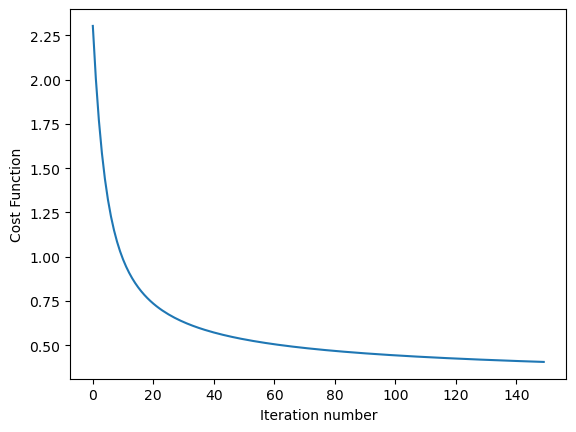

softmax test_error= 0.10050000000000003


In [33]:
print('softmax test_error=', run_softmax_on_MNIST(temp_parameter=1))

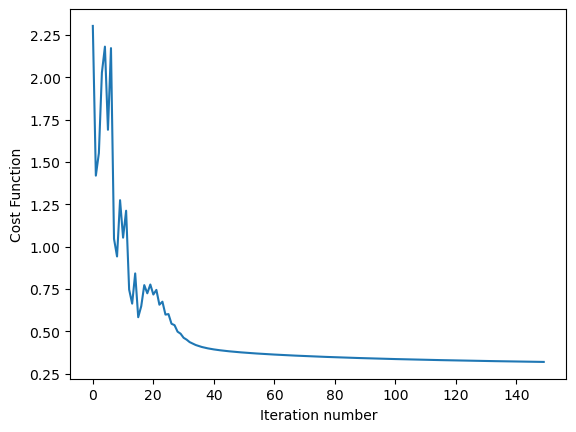

softmax test_error= 0.08399999999999996


In [34]:
print('softmax test_error=', run_softmax_on_MNIST(temp_parameter=0.5))

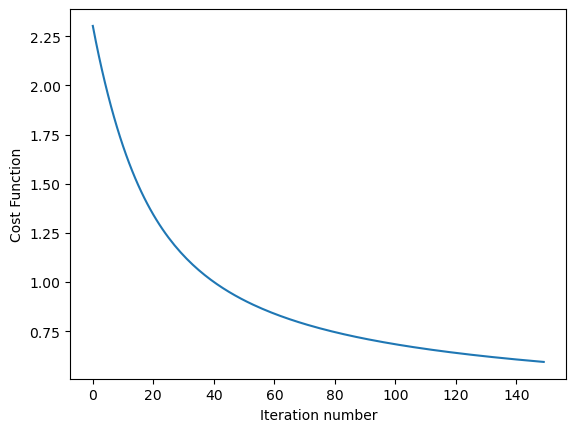

softmax test_error= 0.1261


In [36]:
print('softmax test_error=', run_softmax_on_MNIST(temp_parameter=2))

In [37]:
def update_y(train_y, test_y):
    """
    Changes the old digit labels for the training and test set for the new (mod 3)
    labels.

    Args:
        train_y - (n, ) NumPy array containing the labels (a number between 0-9)
                 for each datapoint in the training set
        test_y - (n, ) NumPy array containing the labels (a number between 0-9)
                for each datapoint in the test set

    Returns:
        train_y_mod3 - (n, ) NumPy array containing the new labels (a number between 0-2)
                     for each datapoint in the training set
        test_y_mod3 - (n, ) NumPy array containing the new labels (a number between 0-2)
                    for each datapoint in the test set
    """
    #YOUR CODE HERE
    return train_y % 3, test_y % 3

def run_softmax_on_MNIST_mod(temp_parameter=1):
    """
    Trains softmax, classifies test data, computes test error, and plots cost function

    Runs softmax_regression on the MNIST training set and computes the test error using
    the test set. It uses the following values for parameters:
    alpha = 0.3
    lambda = 1e-4
    num_iterations = 150

    Saves the final theta to ./theta.pkl.gz

    Returns:
        Final test error
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    train_y, test_y = update_y(train_y, test_y)
    theta, cost_function_history = softmax_regression(train_x, train_y, temp_parameter, alpha=0.3, lambda_factor=1.0e-4, k=10, num_iterations=150)
    plot_cost_function_over_time(cost_function_history)
    test_error = compute_test_error(test_x, test_y, theta, temp_parameter)
    # Save the model parameters theta obtained from calling softmax_regression to disk.
    write_pickle_data(theta, "./theta_mod.pkl.gz")
    
    return test_error


* After updating y by y % 3, our model performs worse than before, because trying to find similarities between 2, 5 and 8 are more difficult than differentiating them

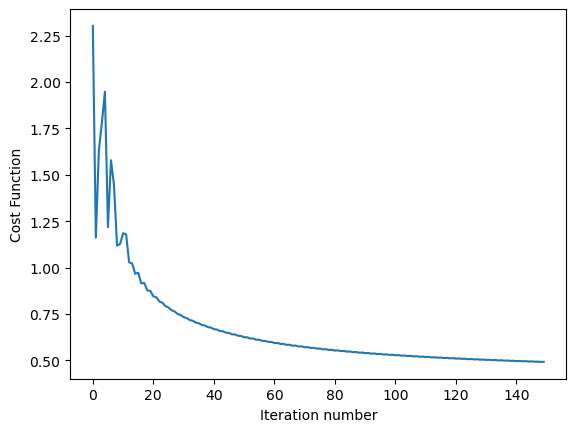

softmax test_error (with mod 3)= 0.18720000000000003


In [38]:
print('softmax test_error (with mod 3)=', run_softmax_on_MNIST_mod(temp_parameter=1))